<a href="https://colab.research.google.com/github/patisankar/customer-coupon-acceptance/blob/main/module5_dirver_coupon_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px

1. Load data

In [2]:
data = pd.read_csv('data/coupons.csv')

2. Investigate the dataset for missing or problematic data.


In [3]:
percent_missing_per_column = data.isnull().sum() * 100 / len(data)
print(percent_missing_per_column)

destination              0.000000
passanger                0.000000
weather                  0.000000
temperature              0.000000
time                     0.000000
coupon                   0.000000
expiration               0.000000
gender                   0.000000
age                      0.000000
maritalStatus            0.000000
has_children             0.000000
education                0.000000
occupation               0.000000
income                   0.000000
car                     99.148534
Bar                      0.843582
CoffeeHouse              1.710817
CarryAway                1.190476
RestaurantLessThan20     1.024913
Restaurant20To50         1.490066
toCoupon_GEQ5min         0.000000
toCoupon_GEQ15min        0.000000
toCoupon_GEQ25min        0.000000
direction_same           0.000000
direction_opp            0.000000
Y                        0.000000
dtype: float64


3. Decide what to do about your missing data -- drop, replace, other
Car column has 99% missing data. Hence, we can drop it. Bar : 0.8%, CoffeeHouse, CarAway, RestaurantLessThan20, Restaurant20To50 have 1%. We could fill with Mode value.

In [4]:
data= data.drop('car', axis=1)

In [5]:
data['Bar'] = data['Bar'].fillna(data['Bar'].mode()[0]);
data['CoffeeHouse'] = data['CoffeeHouse'].fillna(data['CoffeeHouse'].mode()[0]);
data['CarryAway'] = data['CarryAway'].fillna(data['CarryAway'].mode()[0]);
data['RestaurantLessThan20'] = data['RestaurantLessThan20'].fillna(data['RestaurantLessThan20'].mode()[0]);
data['Restaurant20To50'] = data['Restaurant20To50'].fillna(data['Restaurant20To50'].mode()[0]);


4. What proportion of the total observations chose to accept the coupon?

In [6]:
coupon_df = data[['coupon','Y']].copy()
coupon_df.groupby('coupon')['Y'].value_counts(normalize=True)


coupon                 Y
Bar                    0    0.589985
                       1    0.410015
Carry out & Take away  1    0.735478
                       0    0.264522
Coffee House           0    0.500751
                       1    0.499249
Restaurant(20-50)      0    0.558981
                       1    0.441019
Restaurant(<20)        1    0.707107
                       0    0.292893
Name: proportion, dtype: float64

In [7]:
#optizied with groupby + filter
coupon_accepted_count = coupon_df[coupon_df['Y'] == 1].groupby('coupon')['Y'].count()
total_count = coupon_df.groupby('coupon')['Y'].count()

accepted_coupon_proportion = coupon_accepted_count / total_count

accepted_coupon_proportion


,Y
coupon,
Bar,0.410015
Carry out & Take away,0.735478
Coffee House,0.499249
Restaurant(20-50),0.441019
Restaurant(<20),0.707107


Use a bar plot to visualize the coupon column.

In [8]:
def brute_force_univariate_analysis(column_name):

  df = pd.DataFrame(list(data[column_name].unique()), columns=[column_name])
  df['Total'] = list(data.groupby(column_name).Y.count())
  df['Accepted'] = list(data[data.Y == 1].groupby(column_name).Y.count())
  df['Rejected'] = list(data[data.Y == 0].groupby(column_name).Y.count())
  df['Accepted%'] = round(df['Accepted']/df['Total']*100, 3)
  df['Rejected%'] = round(df['Rejected']/df['Total']*100, 3)
  df = df.sort_values(by='Total', ascending=False)
  return df

In [9]:
#optimized with grp + aggr
def univariate_analysis(df, column_name):
  summary_df = df.groupby(column_name)['Y'].agg(
    Total='count',
    Accepted = lambda x: (x==1).sum(),
    Rejected = lambda x: (x==0).sum()
   )
  summary_df['Accepted%'] = round(summary_df['Accepted'] / summary_df['Total'] * 100, 3)
  summary_df['Rejected%'] = round(summary_df['Rejected'] / summary_df['Total'] * 100, 3)
  return summary_df.reset_index().sort_values(by='Total', ascending=False)


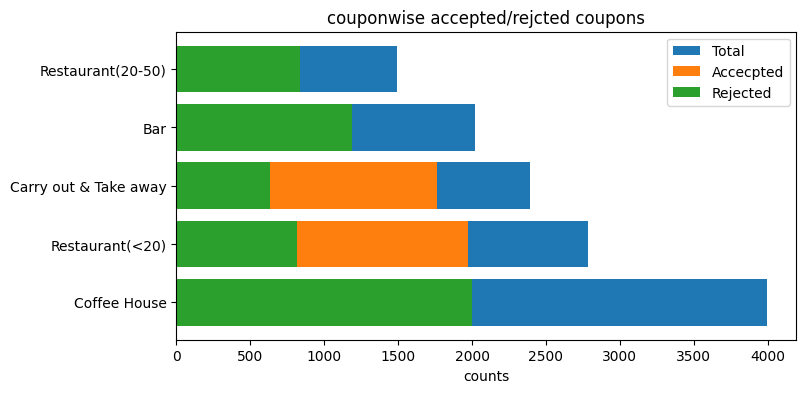

,coupon,Total,Accepted,Rejected,Accepted%,Rejected%
2,Coffee House,3996,1995,2001,49.925,50.075
4,Restaurant(<20),2786,1970,816,70.711,29.289
1,Carry out & Take away,2393,1760,633,73.548,26.452
0,Bar,2017,827,1190,41.001,58.999
3,Restaurant(20-50),1492,658,834,44.102,55.898


In [10]:
column_name = 'coupon'
coupon_summary_df = univariate_analysis(coupon_df, column_name)
fig = plt.subplots(figsize = (8,4))
plt.barh(coupon_summary_df[column_name], coupon_summary_df['Total'])
plt.barh(coupon_summary_df[column_name], coupon_summary_df['Accepted'])
plt.barh(coupon_summary_df[column_name], coupon_summary_df['Rejected'])
plt.legend(labels = ['Total', 'Accecpted','Rejected'])
plt.xlabel('counts')
plt.title(column_name+ 'wise accepted/rejcted coupons')
plt.show()
coupon_summary_df

From above bar graph, we do see coffee House coupon has more acceptance.

Use a histogram to visualize the temperature column.

In [11]:
column_name = 'temperature'
temp_df = univariate_analysis(data[[column_name, 'Y']], column_name)
fig = px.histogram(temp_df,x=column_name , y='Accepted', color = column_name, nbins=3, text_auto=True, title="Accecpted by Temperature" )

fig.show()
temp_df

,temperature,Total,Accepted,Rejected,Accepted%,Rejected%
2,80,6528,3919,2609,60.034,39.966
1,55,3840,2061,1779,53.672,46.328
0,30,2316,1230,1086,53.109,46.891


From above histogram, we can tell 60% accepted at temperature 30,

**Investigating the Bar Coupons**

Now, we will lead you through an exploration of just the bar related coupons.

Create a new DataFrame that contains just the bar coupons.

In [12]:

column_name = 'Bar'
bar_df = univariate_analysis(data[[column_name, 'Y']], column_name)
bar_df


,Bar,Total,Accepted,Rejected,Accepted%,Rejected%
4,never,5304,2822,2482,53.205,46.795
3,less1,3482,1963,1519,56.376,43.624
0,1~3,2473,1538,935,62.192,37.808
1,4~8,1076,686,390,63.755,36.245
2,gt8,349,201,148,57.593,42.407


What proportion of bar coupons were accepted?

Compare the acceptance rate between those who went to a bar 3 or fewer times a month to those who went more.

In [17]:
# optimized
bar_frequency_3_or_fewer = ['less1', '1~3']
bar_frequency_more_than_3 = ['4~8', 'gt8']
bar_df['category'] = 'Other'
bar_df.loc[bar_df['Bar'].isin(bar_frequency_3_or_fewer), 'category'] = '3 or fewer'
bar_df.loc[bar_df['Bar'].isin(bar_frequency_more_than_3), 'category'] = 'more than 3'
bar_df.loc[bar_df['Bar'] == 'never', 'category'] = 'never'

acceptance_rates = bar_df.groupby('category')['Y'].mean()

acceptance_rates

/tmp/ipython-input-833533385.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Y
category,
3 or fewer,0.587909
more than 3,0.622456
never,0.532051


Compare the acceptance rate between drivers who go to a bar more than once a month and are over the age of 25 to the all others. Is there a difference?

In [15]:
bar_visits_more_than_once = ['1~3', '4~8', 'gt8']
over_25 = ['26', '31', '36', '41', '46', '50plus']

# Drivers who go to a bar more than once a month AND are over 25
group1 = data[(data['Bar'].isin(bar_visits_more_than_once)) & (data['age'].isin(over_25))]

# Group 2: All other drivers
group2 = data[~((data['Bar'].isin(bar_visits_more_than_once)) & (data['age'].isin(over_25)))]

# Calculate acceptance rates
rate1 = group1['Y'].mean()
rate2 = group2['Y'].mean()

print(f"Acceptance rate for frequent bar-goers over 25: {rate1:.2%}")
print(f"Acceptance rate for all other drivers: {rate2:.2%}")

Acceptance rate for frequent bar-goers over 25: 62.15%
Acceptance rate for all other drivers: 55.35%


Use the same process to compare the acceptance rate between drivers who go to bars more than once a month and had passengers that were not a kid and had occupations other than farming, fishing, or forestry.

In [16]:
bar_visits_more_than_once = ['1~3', '4~8', 'gt8']
passengers_not_kid = 'Kid'
excluded_occupations = ['Farming', 'Fishing', 'Forestry']

# Group 1: Drivers who meet all criteria
group1 = data[
    (data['Bar'].isin(bar_visits_more_than_once)) &
    (data['passanger'] != passengers_not_kid) &
    (~data['occupation'].isin(excluded_occupations))
]

# Group 2: All other drivers
group2 = data[
    ~((data['Bar'].isin(bar_visits_more_than_once)) &
    (data['passanger'] != passengers_not_kid) &
    (~data['occupation'].isin(excluded_occupations)))
]

# Calculate acceptance rates
rate1 = group1['Y'].mean()
rate2 = group2['Y'].mean()

print(f"Acceptance rate for specific group: {rate1:.2%}")
print(f"Acceptance rate for all other drivers: {rate2:.2%}")

Acceptance rate for specific group: 62.21%
Acceptance rate for all other drivers: 54.46%


Compare the acceptance rates between those drivers who:
* go to bars more than once a month, had passengers that were not a kid, and were not widowed OR
* go to bars more than once a month and are under the age of 30 OR
* go to cheap restaurants more than 4 times a month and income is less than 50K.

In [18]:
bar_visits_more_than_once = ['1~3', '4~8', 'gt8']
under_30 = ['21', '26']
cheap_rest_more_than_4 = 'gt4'
income_less_than_50k = ['$37500 - $49999', '$25000 - $37499', '$12500 - $24999', 'Less than $12500']

condition1 = (
    data['Bar'].isin(bar_visits_more_than_once) &
    (data['passanger'] != 'Kid') &
    (data['maritalStatus'] != 'Widowed')
)

condition2 = (
    data['Bar'].isin(bar_visits_more_than_once) &
    (data['age'].isin(under_30))
)

condition3 = (
    (data['RestaurantLessThan20'] == cheap_rest_more_than_4) &
    (data['income'].isin(income_less_than_50k))
)

# Group 1: Drivers who satisfy ANY of the conditions (OR)
specific_group = data[condition1 | condition2 | condition3]

# Group 2: All other drivers (using the ~ operator to invert the mask)
other_drivers = data[~(condition1 | condition2 | condition3)]

# Calculate acceptance rates
rate_specific_group = specific_group['Y'].mean()
rate_other_drivers = other_drivers['Y'].mean()

print(f"Acceptance rate for specific group: {rate_specific_group:.2%}")
print(f"Acceptance rate for all other drivers: {rate_other_drivers:.2%}")

Acceptance rate for specific group: 62.21%
Acceptance rate for all other drivers: 54.46%


Based on these observations, what do you hypothesize about drivers who accepted the bar coupons?

**Independent Investigation**
Using the bar coupon example as motivation, you are to explore one of the other coupon groups and try to determine the characteristics of passengers who accept the coupons.